# Introduction:

The current notebook develops a model to predict the total damages and the number of people affected by disasters.

For this, two types of models are used:

1. A base model that uses a country-fixed effect and a set of independent variables:
- "ln_population_density"
- "ln_population_density_squared"
-  "population"
-  "ln_gdp_pc"
-  "square_ln_gdp_p"
-  "precip_deviation"
-  "co2"

This base model does not use any geospatial component and predicts the damages and total number of people affected by Hydrometereolofical disasters.

2. A geospatial model that calculates the distance from the disaster to the closest river, and includes interaction between that distance and a dummy variable equal to 1 if the river has a high flooding risk (which means it has "ORD_FLOW" = 1). Besides the distance from the closest river and its interaction ter, the model uses as independent variables:
- "ln_population_density"
- "ln_population_density_squared"
- "population"
- "log_damage_floods"
- "ln_gdp_pc"
- "square_ln_gdp_p"
- "precip_deviation"
-  "co2"

Given that the causal link between storm damage and rivers, is precisely the possibility of floods, this second model uses only the damages caused by floods.

It is important to highlight that the number of disaster observations with a non-zero and non-NaN total damage or affected people value is limited. This significantly reduces the sample size for the damage models.

Additionally, for the river distance models, we require the disaster latitude and longitude data, which reduces even more the available information.

The effect of the different variables on the available data can be seen on the observations for each model:
1. Base people affected model: 2154
2. Base damage model: 1069
3. Geospatial-river people affected model: 742
4. Geospatial damages model: 269

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)

import sys
from pyprojroot import here
sys.path.append("..") 

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage, create_floods_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY, LAOS_LOCATION_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Define helper functions

In [3]:
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset

def add_data(features: list[str], target: str, df: pd.DataFrame, add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
       #time = pm.Data("time", df["time_period"])
    if add_time:
        return X, Y, time
    else:
        return X,Y

In [4]:
# Function to create plot inputs
def generate_plot_inputs(target_variable: str, idata, disaster_type: str = "hydrological_disasters", df = pd.DataFrame ):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[target_variable, "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [5]:
#Plotting function
def plotting_function(idata, country: str, df: pd.DataFrame, target_variable: str):
    df_predictions = generate_plot_inputs(idata = idata, df = df, target_variable = target_variable)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label=f'Mean Predicted {target_variable}')
    ax.scatter(data["year"], data[target_variable], color='k', label=f'Actual {target_variable}')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel(F"{target_variable}")
    
    plt.show();
    

# Importing and cleaning data

In [6]:
rep_df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

In [7]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


# Plotting maps

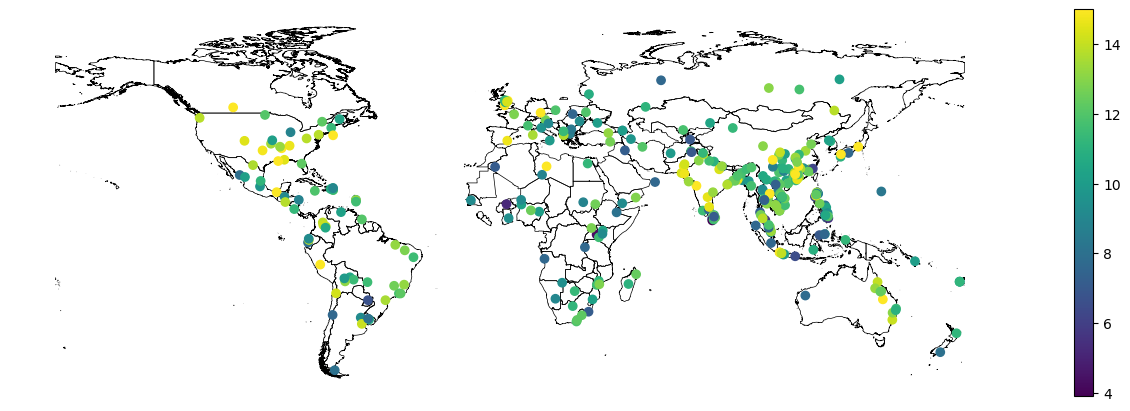

In [8]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
ax.axis('off')
plt.show()

In [9]:
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

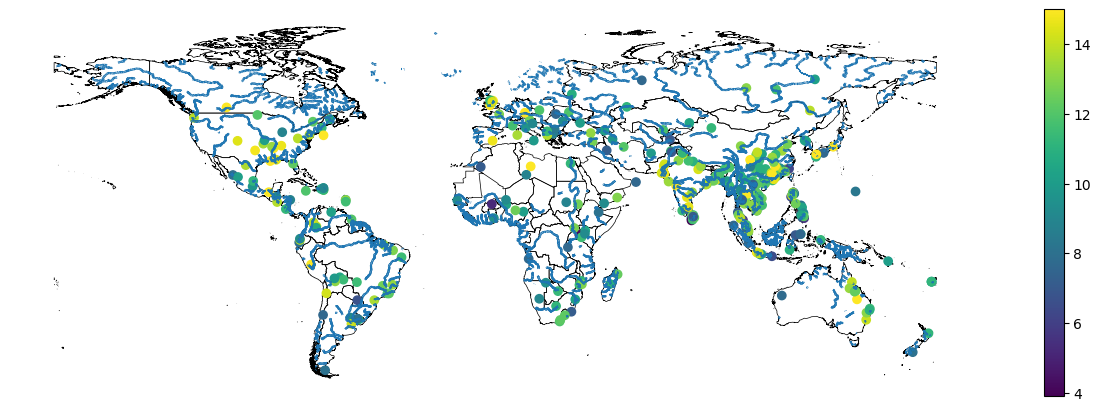

In [10]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
big_rivers.plot(ax=ax)
ax.axis('off')
plt.show()

In [11]:
lon_min, lat_min, lon_max, lat_max = laos.bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

In [12]:
laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [13]:
point_river_distance = get_distance_to_rivers(big_rivers, laos_points)

  0%|          | 0/2980 [00:00<?, ?it/s]

In [16]:
#Floods damages and people_affected
damage_df_f = create_floods_rivers_damage()
merged_df_f = pd.merge(damage_df_f, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

#Create different "ORDFLOW" dummies
merged_df_f["ORD_FLOW_1"] = 0
for i in merged_df_f.index.values:
    if merged_df_f.loc[i, "ORD_FLOW"] == 1:
        merged_df_f.loc[i, "ORD_FLOW_1"] = 1

#Create the variable intrecation between closest river and ORD_FLOW
merged_df_f["closest_river_int_ORD_FLOW_1"] = merged_df_f["closest_river"] * merged_df_f["ORD_FLOW_1"]


#Create log of squared population density
merged_df_f["ln_population_density_squared"] =   (2 *merged_df_f["ln_population_density"])

**Note:** Unfortunately there is only one event in LAO with data for Lat, Long and Total damages, and it is an earthquake.

This is why we are using the next dictionary to add manually the coordinates of disasters in LAO that have registered damages:

In [17]:
LAOS_LOCATION_DICTIONARY

{'Vientiane': {'Latitude': 17.9757, 'Longitude': 102.6331},
 'Louang-Namtha, Bolikhamxai, Khammouan, Savannakhet, Champasak, Salavan, Vientiane, Vientiane capital province': {'Latitude': 19.0,
  'Longitude': 102.0},
 'Xay, Beng districts (Oudomxai province), Khop, Xienghone, Ngeun, Xayabury districts (Xaignabouli province), Bolikhanh, Paksane, Pakkading, Thaphabath districts (Bolikhamxai province), Nakai, Mahaxay, Nongbok, Xebangfay, Hinboon districts (Khammuan province), Pek, Kham, Thathom districts (Xiangkhouang province), Kasy, Feuang, Mad, Hom districts (Vientiane province)': {'Latitude': 19.5,
  'Longitude': 103.5},
 'Salavan, Champasak, Attapu, Savannakhet, Xekong provinces': {'Latitude': 16.5,
  'Longitude': 106.0},
 'Houaphan, Bolikhamxai, Khammouan, Louang-Namtha provinces': {'Latitude': 19.0,
  'L`ongitude': 104.0},
 'Luang Prabang city (Louangphrabang distrcit, Louangphabang province), Oudomxai, Salavan, Xaignabouli, Xiangkhouang, Houaphan, Bokeo provinces': {'Latitude': 19.

Text(0.5, 1.0, 'Points close to big rivers in Lao')

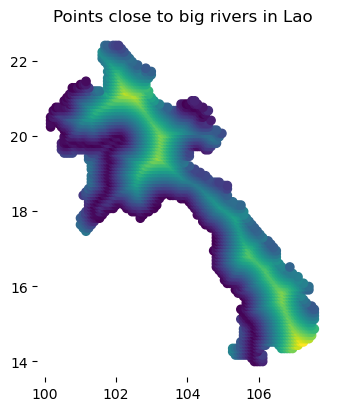

In [18]:
laos_points.join(point_river_distance['closest_river']).plot('closest_river')
plt.title("Points close to big rivers in Lao")

# Base models

## Base people_affected model

In [19]:
#df for modeling

rep_df["log_affected_hydro"] = np.log(rep_df["Total_Affected_hydro"].replace({0.0: np.nan}))

rep_df["ln_population_density_squared"] = (2 *rep_df["ln_population_density"])

df_1 = rep_df[["ln_population_density", "ln_population_density_squared",  "population", 
               "ISO","year" ,
               "log_affected_hydro",
               "ln_gdp_pc", "square_ln_gdp_p",
                "precip_deviation", "co2"]].dropna()

X_1 = (df_1.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx, ISO =  pd.factorize(df_1["ISO"])
coords = {
    'ISO':ISO,
    'year':df_1["year"].unique(),
    'obs_idx':df_1.index,
    'feature': X_1.drop(columns = ["log_affected_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_1.set_index(['ISO', 'year']).index, 'obs_idx')

In [20]:
#Store the sample size in the DF
samples_size = pd.DataFrame(columns = ["Sample size"] )
samples_size.loc["base_people_affected_model"] = df_1.shape[0]

In [21]:
#Simple Damages model
with pm.Model(coords=coords) as base_people_affected_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_affected_hydro", df = X_1 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [22]:
#Sampling
with base_people_affected_model:
    base_people_affected_idata =sample_or_load(
            fp="base_people_affected_model",
            resample=True,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    base_people_affected_idata = base_people_affected_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.11,31
,2000,0,0.10,31
,2000,0,0.12,31
,2000,0,0.08,63
,2000,0,0.11,31
,2000,0,0.10,31
,2000,0,0.12,31
,2000,0,0.13,31


Sampling: [y_hat]


Output()

Output()

In [23]:
az.summary(base_people_affected_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[ln_population_density],-1.696,0.706,-2.967,-0.249,0.139,0.099,26.0,84.0,1.22
beta[ln_population_density_squared],-1.133,0.700,-2.343,0.182,0.136,0.097,26.0,82.0,1.24
beta[population],0.032,0.014,0.007,0.059,0.001,0.001,316.0,805.0,1.02
beta[ln_gdp_pc],-1.398,0.824,-2.961,0.045,0.178,0.128,21.0,93.0,1.32
beta[square_ln_gdp_p],-0.162,0.178,-0.484,0.175,0.019,0.014,89.0,327.0,1.08
beta[precip_deviation],0.026,0.003,0.021,0.033,0.000,0.000,8855.0,5741.0,1.00
beta[co2],0.142,0.042,0.064,0.223,0.004,0.003,119.0,462.0,1.06
sigma,1.685,0.027,1.635,1.736,0.000,0.000,8712.0,5910.0,1.00
sigma_log__,0.522,0.016,0.491,0.551,0.000,0.000,8712.0,5910.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


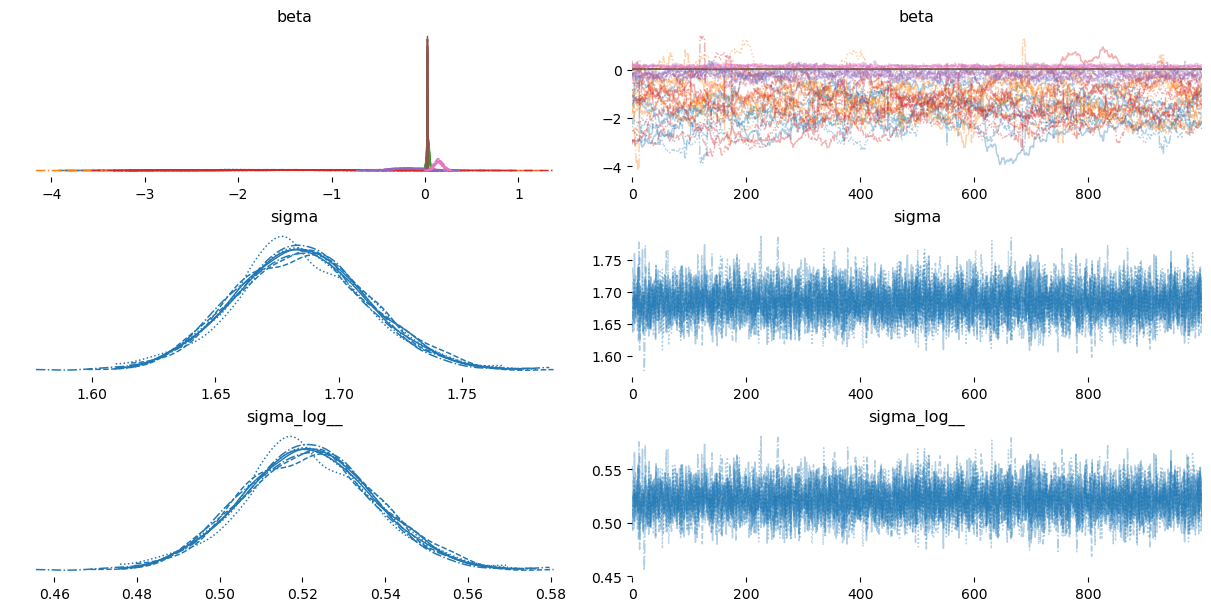

In [24]:
az.plot_trace(base_people_affected_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

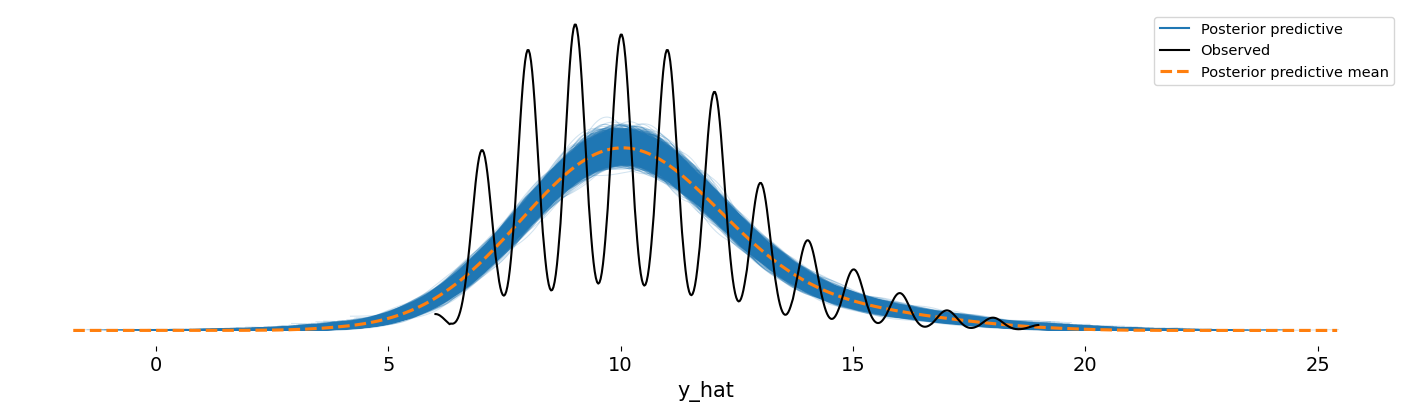

In [25]:
az.plot_ppc(base_people_affected_idata);

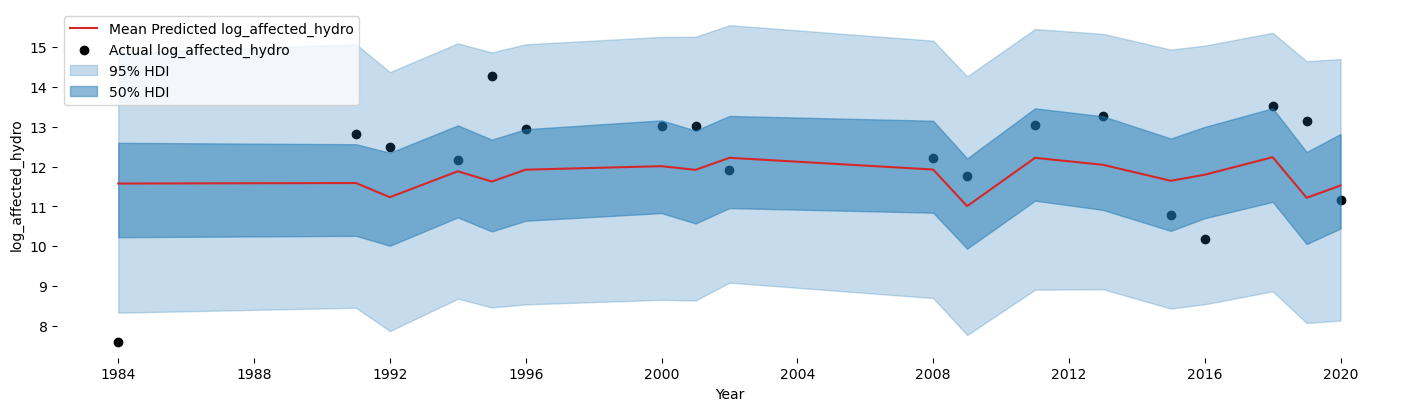

In [26]:
plotting_function(idata =base_people_affected_idata , 
                  country = "LAO",
                  df = df_1 ,
                 target_variable= "log_affected_hydro")

## Base damage model

In [27]:
#df for modeling

rep_df["log_damage_adjusted_hydro"] = np.log(rep_df["Total_Damage_Adjusted_hydro"].replace({0.0: np.nan}))





df_2 = rep_df[["ln_population_density", "ln_population_density_squared",  "population",  "ISO",
                  "year" , "log_damage_adjusted_hydro", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_2 = (df_2.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_2_idx, ISO_2 =  pd.factorize(df_2["ISO"])
coords = {
    'ISO':ISO_2,
    'year':df_2["year"].unique(),
    'obs_idx':df_2.index,
    'feature': X_2.drop(columns = ["log_damage_adjusted_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_2.set_index(['ISO', 'year']).index, 'obs_idx')

In [28]:
#Store the sample size in the DF
samples_size.loc["simple_damages_model"] = df_2.shape[0]

In [29]:
#Simple Damages model
with pm.Model(coords=coords) as simple_damages_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_adjusted_hydro", df = X_2 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_2_idx] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [30]:
#Sampling
with simple_damages_model:
    simple_damages_idata =sample_or_load(
            fp="simple_damages_model",
            resample= True,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    simple_damages_idata = simple_damages_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,31
,2000,0,0.12,31
,2000,0,0.11,31
,2000,0,0.12,31
,2000,0,0.12,31
,2000,0,0.11,31
,2000,0,0.12,31
,2000,0,0.11,31


Sampling: [y_hat]


Output()

Output()

In [31]:
az.summary(simple_damages_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[ln_population_density],-1.653,0.700,-2.856,-0.269,0.097,0.074,52.0,103.0,1.14
beta[ln_population_density_squared],-1.680,0.804,-3.118,-0.216,0.125,0.100,42.0,55.0,1.14
beta[population],0.030,0.023,-0.012,0.074,0.001,0.001,309.0,504.0,1.03
beta[ln_gdp_pc],-1.614,0.853,-3.330,-0.037,0.137,0.097,40.0,79.0,1.14
beta[square_ln_gdp_p],0.545,0.274,-0.009,1.040,0.020,0.014,181.0,397.0,1.04
beta[precip_deviation],0.027,0.006,0.016,0.038,0.000,0.000,9275.0,5723.0,1.00
beta[co2],0.036,0.073,-0.104,0.169,0.006,0.004,166.0,237.0,1.05
sigma,2.103,0.050,2.008,2.193,0.001,0.000,8739.0,6127.0,1.00
sigma_log__,0.743,0.024,0.697,0.785,0.000,0.000,8739.0,6127.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


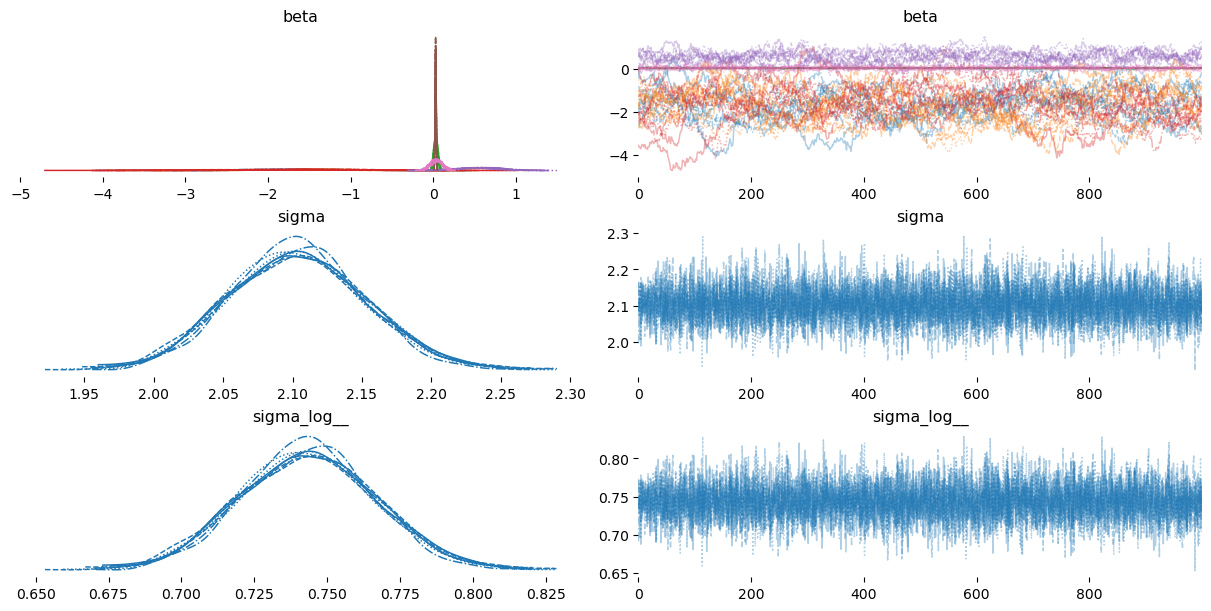

In [32]:
az.plot_trace(simple_damages_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


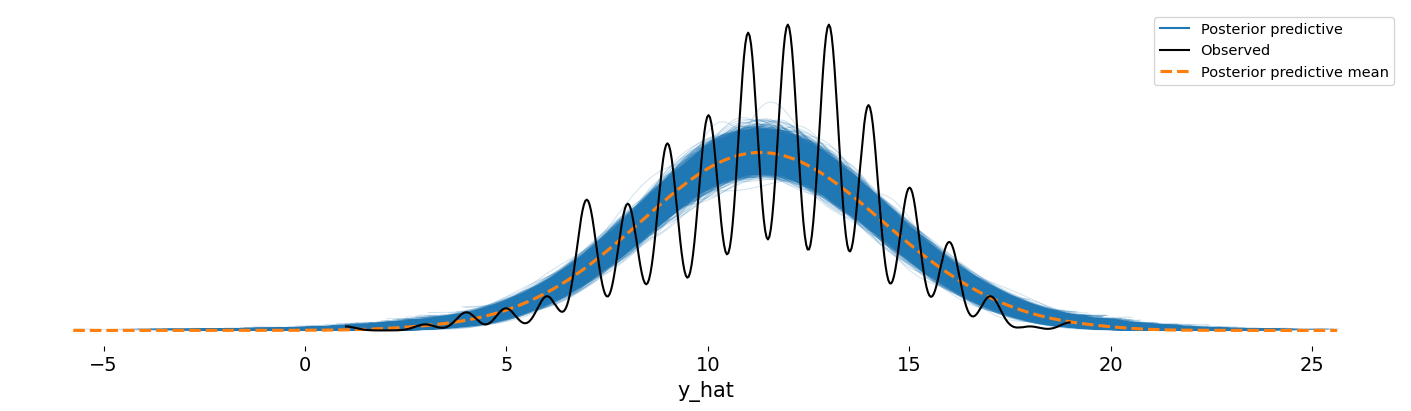

In [33]:
az.plot_ppc(simple_damages_idata);

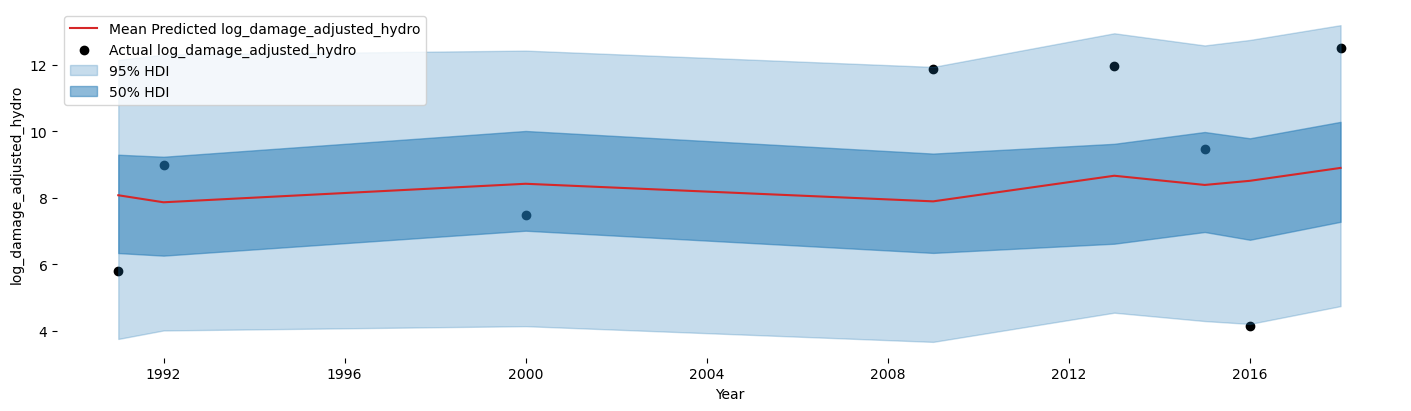

In [35]:
plotting_function(idata =simple_damages_idata , 
                  country = "LAO",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

# Geospatial-river models

## Geospatial-river people_affected model

In [43]:

df_3 = merged_df_f[[ "closest_river",
                    #"ORD_FLOW",
                    "closest_river_int_ORD_FLOW_1",
                    "ln_population_density", "ln_population_density_squared","population", 
                    "ISO","year" , "log_affected_floods",
                    "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()



X_3 = (df_3.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx_3, ISO_3 =  pd.factorize(df_3["ISO"])
coords = {
    'ISO':ISO_3,
    'year':df_3["year"].unique(),
    'obs_idx':df_3.index,
    'feature': X_3.drop(columns = ["log_affected_floods"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_3.set_index(['ISO', 'year']).index, 'obs_idx')

In [45]:
#damages_with_river_model
with pm.Model(coords=coords) as affected_people_with_river_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_affected_floods", df = X_3 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx_3] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [46]:
#Store the sample size in the DF
samples_size.loc["affected_people_with_river_model"] = df_3.shape[0]

In [47]:
#Sampling
with affected_people_with_river_model:
    affected_people_with_river_idata =sample_or_load(
            fp="affected_people_with_river_model",
            resample=True,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    affected_people_with_river_idata = affected_people_with_river_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.10,31
,2000,0,0.10,31
,2000,0,0.09,63
,2000,0,0.09,63
,2000,0,0.09,31
,2000,0,0.09,63
,2000,0,0.00,1023
,2000,0,0.10,31


Sampling: [y_hat]


Output()

Output()

In [48]:
az.summary(affected_people_with_river_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[closest_river],0.086,0.210,-0.002,0.642,0.074,0.054,22.0,5145.0,1.27
beta[closest_river_int_ORD_FLOW_1],-0.654,0.883,-2.366,0.878,0.135,0.096,49.0,219.0,1.13
beta[ln_population_density],-0.846,0.864,-2.610,0.528,0.148,0.106,35.0,120.0,1.18
beta[ln_population_density_squared],-0.711,0.868,-2.377,0.930,0.074,0.053,144.0,234.0,1.08
beta[population],0.175,0.522,-0.130,1.543,0.182,0.135,18.0,116.0,1.41
beta[ln_gdp_pc],-0.810,0.864,-2.498,0.764,0.127,0.090,49.0,290.0,1.13
beta[square_ln_gdp_p],-0.080,0.575,-1.141,0.830,0.092,0.065,44.0,372.0,1.15
beta[precip_deviation],-0.221,0.663,-1.974,0.045,0.233,0.171,22.0,8.0,1.27
beta[co2],0.469,0.232,0.121,0.889,0.049,0.035,24.0,10.0,1.26
sigma,2.087,0.492,1.826,3.384,0.173,0.127,22.0,6002.0,1.27


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


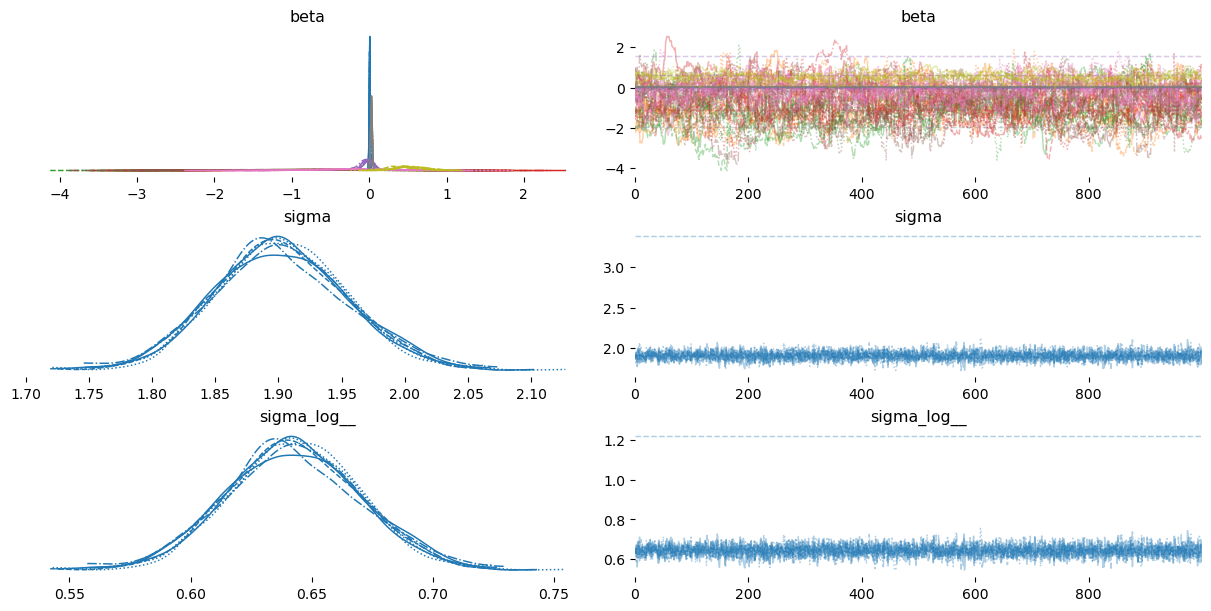

In [49]:
az.plot_trace(affected_people_with_river_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


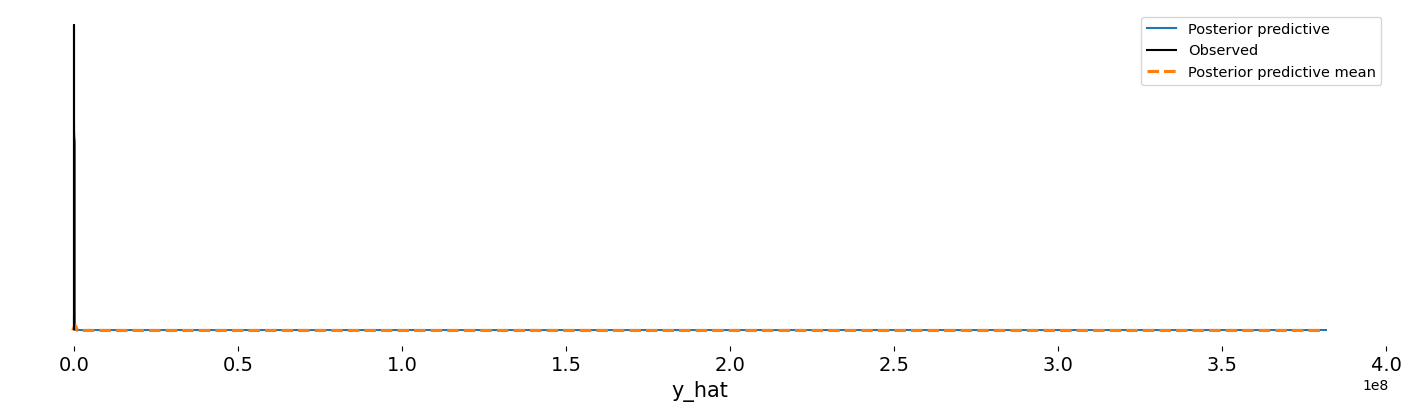

In [50]:
az.plot_ppc(affected_people_with_river_idata);

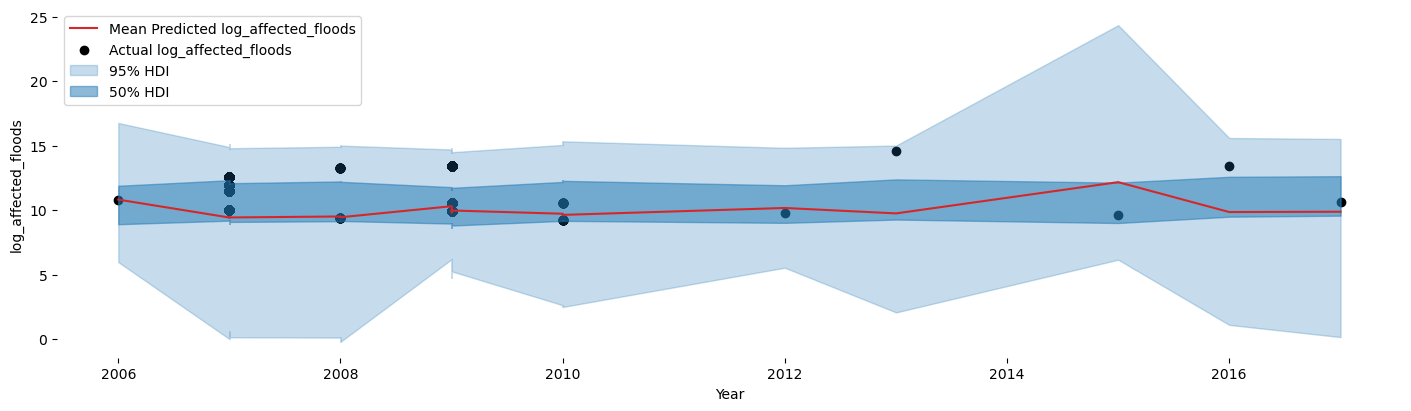

In [61]:
plotting_function(idata =affected_people_with_river_idata , 
                  country = "VNM",
                  df = df_3 ,
                 target_variable= "log_affected_floods")

## Geospatial-river damage model

In [52]:
#df for modeling

df_4 = merged_df_f[[ "closest_river",
                    "closest_river_int_ORD_FLOW_1",
                    "ln_population_density", "ln_population_density_squared","population", 
                    "ISO","year" , "log_damage_floods",
                    "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()



X_4 = (df_4.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx_4, ISO_4 =  pd.factorize(df_4["ISO"])
coords = {
    'ISO':ISO_4,
    'year':df_4["year"].unique(),
    'obs_idx':df_4.index,
    'feature': X_4.drop(columns = ["log_damage_floods"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_4.set_index(['ISO', 'year']).index, 'obs_idx')

In [53]:
#damages_with_river_model
with pm.Model(coords=coords) as damages_with_river_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_floods", df = X_4 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx_4] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [54]:
#Store the sample size in the DF
samples_size.loc["damages_with_river_model"] = df_4.shape[0]

In [55]:
#Sampling
with damages_with_river_model:
    damages_with_river_idata =sample_or_load(
            fp="damages_with_river_model",
            resample=True,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    damages_with_river_idata = damages_with_river_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,31
,2000,0,0.11,31
,2000,0,0.11,31
,2000,0,0.11,31
,2000,0,0.10,31
,2000,0,0.11,31
,2000,0,0.11,31
,2000,0,0.11,31


Sampling: [y_hat]


Output()

Output()

In [56]:
az.summary(damages_with_river_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[closest_river],0.005,0.017,-0.030,0.034,0.000,0.000,6784.0,5674.0,1.00
beta[closest_river_int_ORD_FLOW_1],-0.695,0.874,-2.356,0.930,0.054,0.039,258.0,420.0,1.03
beta[ln_population_density],-0.554,0.912,-2.209,1.179,0.056,0.040,264.0,622.0,1.03
beta[ln_population_density_squared],-0.701,0.881,-2.307,0.971,0.048,0.034,340.0,594.0,1.03
beta[population],0.064,0.111,-0.138,0.276,0.008,0.006,219.0,354.0,1.03
beta[ln_gdp_pc],-0.526,0.884,-2.209,1.060,0.054,0.038,272.0,547.0,1.04
beta[square_ln_gdp_p],1.026,0.694,-0.258,2.404,0.035,0.025,387.0,811.0,1.01
beta[precip_deviation],0.017,0.023,-0.026,0.061,0.000,0.000,4478.0,5376.0,1.00
beta[co2],1.051,0.349,0.385,1.665,0.024,0.017,211.0,473.0,1.03
sigma,2.229,0.114,2.022,2.445,0.002,0.001,4947.0,5517.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


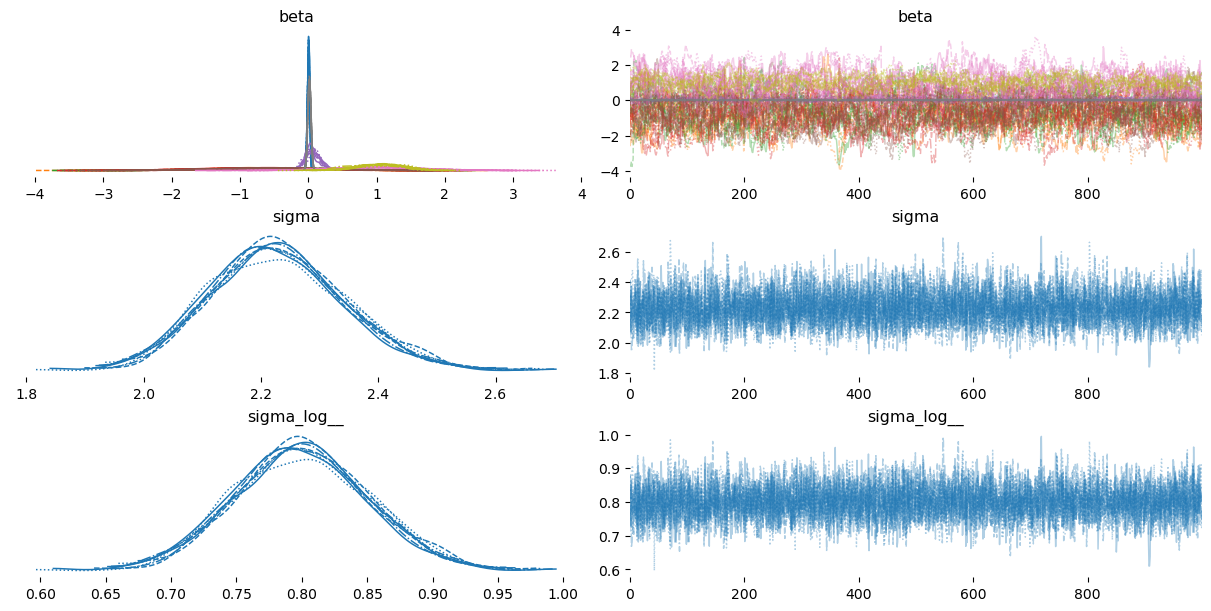

In [57]:
az.plot_trace(damages_with_river_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


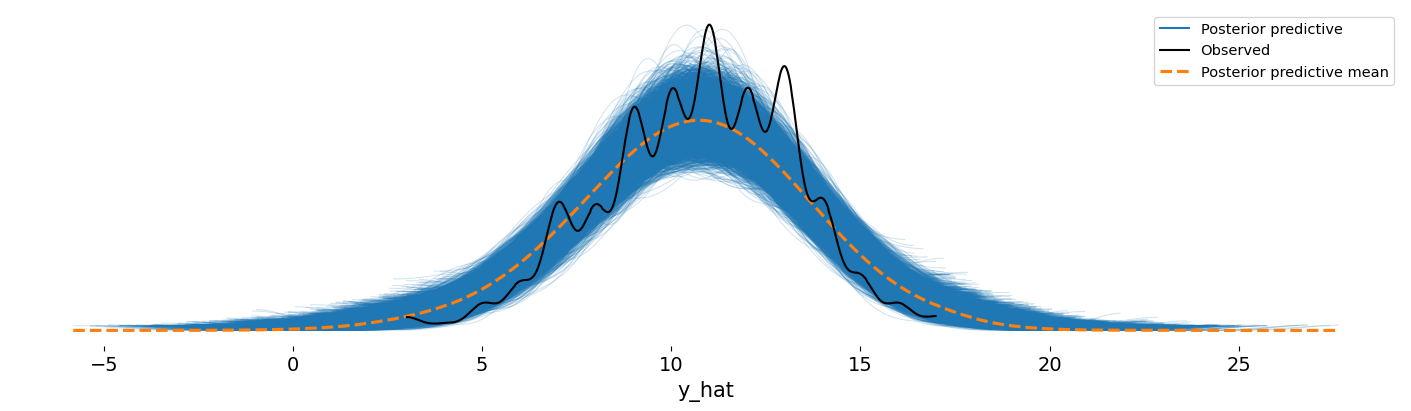

In [58]:
az.plot_ppc(damages_with_river_idata);

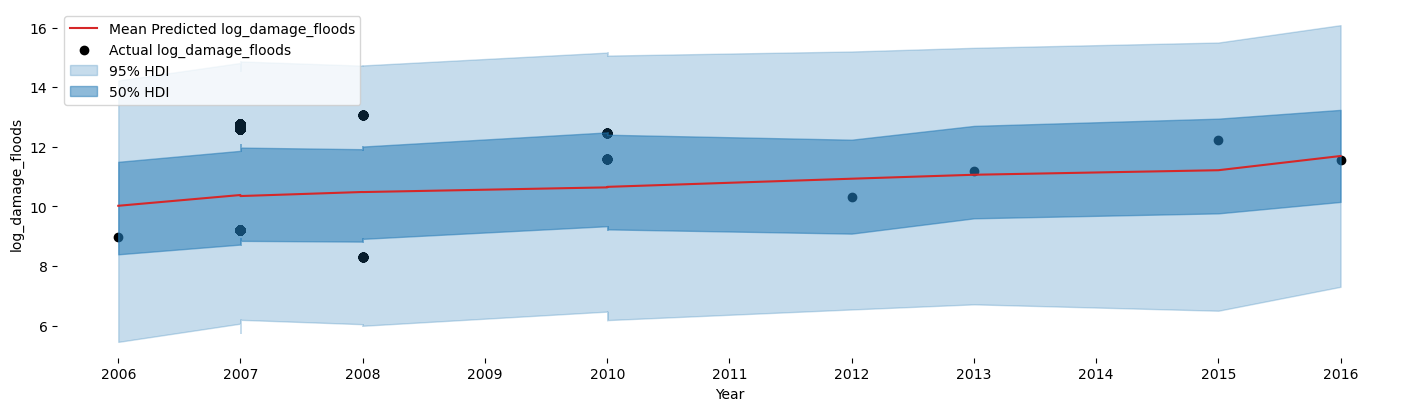

In [62]:
plotting_function(idata =damages_with_river_idata , 
                  country = "VNM",
                  df = df_4 ,
                 target_variable= "log_damage_floods")

# 